## Datasets

**Dataset 1: BoardGameGeek Reviews**

https://www.kaggle.com/datasets/jvanelteren/boardgamegeek-reviews

This dataset contains detailed metadata for a large collection of board games, scraped from BoardGameGeek (BGG)

Files used:

1.  **games_detailed_info2025.csv**: Contains board game metadata, scraped in 2025.
2.  **games_detailed_info.csv** (renamed to **games_detailed_info2022.csv**): Contains board game metadata scraped from BGG in 2022. The file was renamed to avoid confusion during analysis.



**Dataset 2: Board Game Ratings by Country**

https://www.kaggle.com/datasets/thedevastator/board-game-ratings-by-country

This dataset provides user ratings by country and is used to analyze global preferences from the year 2019.

Files used:

1.  **games_detailed_info.xlsx**: Converted to CSV and renamed to **games_detailed_info2019.csv**; contains board game metadata from 2019.
2.  **bggreviews_small.csv** (renamed to **ratings.csv**): Contains individual user ratings for various games.
3.  **users.csv**: Includes information about users, including their country of origin, allowing for regional analysis.

## Data Processing and Cleaning

In [37]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
games19 = pd.read_csv('/content/games_detailed_info2019.csv', index_col='id') #games19['id'].is_unique evaluates to True
games22 = pd.read_csv('/content/games_detailed_info2022.csv', index_col='id')
games25 = pd.read_csv('/content/games_detailed_info2025.csv', index_col='id')

<ipython-input-38-d994eb194eeb>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  games19 = pd.read_csv('/content/games_detailed_info2019.csv', index_col='id') #games19['id'].is_unique evaluates to True
<ipython-input-38-d994eb194eeb>:2: DtypeWarning: Columns (29,48) have mixed types. Specify dtype option on import or set low_memory=False.
  games22 = pd.read_csv('/content/games_detailed_info2022.csv', index_col='id')


In [39]:
def align_dataframes(df1, df2, df3):
    """
    Aligns the three dataframes on common columns.
    Returns cleaned versions: df1_cleaned, df2_cleaned, df3_cleaned
    """

    def clean(df):
        df = df.copy()
        if 'Unnamed: 0' in df.columns:
            df.drop(columns=['Unnamed: 0'], inplace=True)
        if 'primary' in df.columns:
            df.rename(columns={'primary': 'name'}, inplace=True)
        return df

    #Clean each dataframe
    df1 = clean(df1)
    df2 = clean(df2)
    df3 = clean(df3)

    #Get common columns
    common_cols = set(df1.columns) & set(df2.columns) & set(df3.columns)

    #Keep only common columns
    df1 = df1[list(common_cols)]
    df2 = df2[list(common_cols)]
    df3 = df3[list(common_cols)]

    return df1, df2, df3

In [40]:
games19, games22, games25 = align_dataframes(games19, games22, games25)
games19.head(3)

,boardgamedesigner,wishing,wanting,maxplayers,Thematic Rank,name,Party Game Rank,suggested_playerage,owned,boardgameintegration,...,numcomments,numweights,description,minage,minplayers,War Game Rank,type,Customizable Rank,bayesaverage,boardgameexpansion
id,,,,,,,,,,,,,,,,,,,,,
13,['Klaus Teuber'],4729,453,4,NaN,Catan,NaN,"[OrderedDict([('@value', '2'), ('@numvotes', '...",125254,NaN,...,16330,6866,"In Catan (formerly The Settlers of Catan), pla...",10,3,NaN,boardgame,NaN,7.03556,"['20 Jahre Darmstadt Spielt', 'Brettspiel Adve..."
822,['Klaus-JÃ¼rgen Wrede'],5403,498,5,NaN,Carcassonne,NaN,"[OrderedDict([('@value', '2'), ('@numvotes', '...",121717,['Carcassonne: Wheel of Fortune'],...,16180,6950,Carcassonne is a tile-placement game in which ...,8,2,NaN,boardgame,NaN,7.32084,"['20 Jahre Darmstadt Spielt', 'Apothecaries An..."
30549,['Matt Leacock'],7655,614,4,NaN,Pandemic,NaN,"[OrderedDict([('@value', '2'), ('@numvotes', '...",123067,NaN,...,14127,4881,"In Pandemic, several virulent diseases have br...",8,2,NaN,boardgame,NaN,7.54432,['Pandemic: Gen Con 2016 Promos â€“ Z-Force Te...


The cleaned dataframes contain 48 columns, but not all of them are relevant to our analysis. Below are the main columns we will keep and use:

- **id**: Unique BoardGameGeek identifier for each game
- **name**: The name of the game
- **yearpublished**: The year the game was originally published
- **Board Game Rank** (renamed to **rank**): The official rank of the game on BoardGameGeek
- **bayesaverage**: The Bayesian-adjusted average rating. We will use this instead of the simple average, as it provides a more balanced and fair representation of a game's quality
- **usersrated**: Number of users who rated the game
- **averageweight**: A measure of the game's complexity on a 5-point scale from 1 (Light) to 5 (Heavy), indicating how difficult it is to understand and play
- **minplayers** and **maxplayers**: The minimum and maximum number of players supported
- **minplaytime** and **maxplaytime**: Minimum and maximum estimated playtime
- **minage**: Minimum recommended age for players
- **boardgamecategory**: The game's type. This column will be cleaned and grouped into broader categories for analysis
- **numcomments**: Number of user comments. This can be used to measure engagement or highlight top games on the website
- **owned**. **wishing**, **trading**: These columns reflect different stages of user engagement with a game. **owned** indicates how many users have the game in their collection, **wishing** shows how many users want to own it, and **trading** reflects how many users are offering it for trade
- **description**: Used as a preview on the website for top games
- **image**: Game cover image, used for visual display on the website
- **boardgameexpansion**: Indicates the expansions of a game. This can be used to analyze if top-ranked games tend to have expansions


In [41]:
columns_to_keep = [
    'id', 'name', 'yearpublished', 'Board Game Rank', 'bayesaverage',
    'usersrated', 'averageweight', 'minplayers', 'maxplayers',
    'minplaytime', 'maxplaytime', 'minage', 'boardgamecategory',
    'numcomments', 'owned', 'wishing', 'trading',
    'description', 'image', 'boardgameexpansion'
]

#Keep only those columns
games19 = games19[[col for col in columns_to_keep if col in games19.columns]].copy()
games22 = games22[[col for col in columns_to_keep if col in games22.columns]].copy()
games25 = games25[[col for col in columns_to_keep if col in games25.columns]].copy()

#Rename 'Board Game Rank' to 'rank'
games19.rename(columns={'Board Game Rank': 'rank'}, inplace=True)
games22.rename(columns={'Board Game Rank': 'rank'}, inplace=True)
games25.rename(columns={'Board Game Rank': 'rank'}, inplace=True)


In [42]:
def dataframe_summary(df, name):
    """
    Returns a detailed summary of nulls, empty strings, and data types. (similar to .info() but with more information on empty string columns and the %)
    """

    summary = pd.DataFrame(columns=[
        'Column', 'Data Type', 'Total', 'Non-Null',
        'Null %', 'Empty String %'
    ])

    for col in df.columns:
        total = len(df)
        non_null = df[col].notna().sum()
        null_pct = round(((total - non_null) / total) * 100, 2)
        empty_pct = round((df[col].astype(str).str.strip() == '').sum() / total * 100, 2)
        dtype = df[col].dtype

        summary = pd.concat([summary, pd.DataFrame({
            'Column': [col],
            'Data Type': [dtype],
            'Total': [total],
            'Non-Null': [non_null],
            'Null %': [null_pct],
            'Empty String %': [empty_pct]
        })], ignore_index=True)

    print(f"\nDetailed Summary for {name}:\n")
    return summary

In [43]:
dataframe_summary(games19,"games19")

<ipython-input-42-6fdd03c3e9f0>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary = pd.concat([summary, pd.DataFrame({



Detailed Summary for games19:



,Column,Data Type,Total,Non-Null,Null %,Empty String %
0,name,object,17063,17063,0.00,0.0
1,yearpublished,int64,17063,17063,0.00,0.0
2,rank,object,17063,17063,0.00,0.0
3,bayesaverage,float64,17063,17063,0.00,0.0
4,usersrated,int64,17063,17063,0.00,0.0
5,averageweight,float64,17063,17063,0.00,0.0
6,minplayers,int64,17063,17063,0.00,0.0
7,maxplayers,int64,17063,17063,0.00,0.0
8,minplaytime,int64,17063,17063,0.00,0.0
9,maxplaytime,int64,17063,17063,0.00,0.0


In [44]:
dataframe_summary(games22,"games22")

<ipython-input-42-6fdd03c3e9f0>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary = pd.concat([summary, pd.DataFrame({



Detailed Summary for games22:



,Column,Data Type,Total,Non-Null,Null %,Empty String %
0,name,object,21631,21631,0.00,0.0
1,yearpublished,int64,21631,21631,0.00,0.0
2,rank,object,21631,21631,0.00,0.0
3,bayesaverage,float64,21631,21631,0.00,0.0
4,usersrated,int64,21631,21631,0.00,0.0
5,averageweight,float64,21631,21631,0.00,0.0
6,minplayers,int64,21631,21631,0.00,0.0
7,maxplayers,int64,21631,21631,0.00,0.0
8,minplaytime,int64,21631,21631,0.00,0.0
9,maxplaytime,int64,21631,21631,0.00,0.0


In [45]:
dataframe_summary(games25,"games25")

<ipython-input-42-6fdd03c3e9f0>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary = pd.concat([summary, pd.DataFrame({



Detailed Summary for games25:



,Column,Data Type,Total,Non-Null,Null %,Empty String %
0,name,object,27780,27780,0.00,0.0
1,yearpublished,int64,27780,27780,0.00,0.0
2,rank,int64,27780,27780,0.00,0.0
3,bayesaverage,float64,27780,27780,0.00,0.0
4,usersrated,int64,27780,27780,0.00,0.0
5,averageweight,float64,27780,27780,0.00,0.0
6,minplayers,int64,27780,27780,0.00,0.0
7,maxplayers,int64,27780,27780,0.00,0.0
8,minplaytime,int64,27780,27780,0.00,0.0
9,maxplaytime,int64,27780,27780,0.00,0.0


We have values for most of the selected columns. The only attribute with missing data is boardgameexpansion, but the number of available samples is sufficient to include it in our analysis.

In [46]:
def clean_dataframe(df):
    """
    Cleans and parses a dataframe:
    - Parses list columns
    - Converts 'rank' to integer
    - Ensures 'name' and 'description' are strings
    - Drops rows with empty or missing boardgamecategory, rank, yearpublished, or weight
    """
    df = df.copy()

    #Convert 'name' and 'description' to strings
    df['name'] = df['name'].astype(str)
    df['description'] = df['description'].astype(str)

    #Drop rows where rank is "Not Ranked"
    df = df[df['rank'] != 'Not Ranked']

    #Convert 'rank' to integer
    df['rank'] = pd.to_numeric(df['rank'], errors='coerce')

    #Drop rows with missing rank (after conversion)
    df = df[df['rank'].notna()]
    df['rank'] = df['rank'].astype('int64')

    #Drop rows with yearpublished=0 (missing years)
    df = df[df['yearpublished'] != 0]

    #Drop rows with averageweight less than 1 (missing weight)
    df = df[df['averageweight'] != 0]

    #Convert 'boardgamecategory' to list
    df['boardgamecategory'] = df['boardgamecategory'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else []
    )

    #Convert 'boardgameexpansion' to list
    df['boardgameexpansion'] = df['boardgameexpansion'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else []
    )

    #Drop rows with empty or null boardgamecategory
    df = df[df['boardgamecategory'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

    return df

In [47]:
games19 = clean_dataframe(games19)
games22 = clean_dataframe(games22)
games25 = clean_dataframe(games25)

In [48]:
#Re-ordering columns for better readability

ordered_columns = [
    'name', 'yearpublished', 'rank',
    'bayesaverage', 'usersrated', 'numcomments',
    'owned', 'wishing', 'trading',
    'averageweight',
    'minplayers', 'maxplayers',
    'minplaytime', 'maxplaytime',
    'minage',
    'boardgamecategory', 'boardgameexpansion',
    'description', 'image'
]

games19 = games19[ordered_columns]
games22 = games22[ordered_columns]
games25 = games25[ordered_columns]

In [49]:
games19.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16449 entries, 13 to 8256
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                16449 non-null  object 
 1   yearpublished       16449 non-null  int64  
 2   rank                16449 non-null  int64  
 3   bayesaverage        16449 non-null  float64
 4   usersrated          16449 non-null  int64  
 5   numcomments         16449 non-null  int64  
 6   owned               16449 non-null  int64  
 7   wishing             16449 non-null  int64  
 8   trading             16449 non-null  int64  
 9   averageweight       16449 non-null  float64
 10  minplayers          16449 non-null  int64  
 11  maxplayers          16449 non-null  int64  
 12  minplaytime         16449 non-null  int64  
 13  maxplaytime         16449 non-null  int64  
 14  minage              16449 non-null  int64  
 15  boardgamecategory   16449 non-null  object 
 16  boardgame

In [50]:
games19.head(5)

,name,yearpublished,rank,bayesaverage,usersrated,numcomments,owned,wishing,trading,averageweight,minplayers,maxplayers,minplaytime,maxplaytime,minage,boardgamecategory,boardgameexpansion,description,image
id,,,,,,,,,,,,,,,,,,,
13,Catan,1995,327,7.03556,85332,16330,125254,4729,1685,2.3399,3,4,60,120,10,[Negotiation],"[20 Jahre Darmstadt Spielt, Brettspiel Advents...","In Catan (formerly The Settlers of Catan), pla...",https://cf.geekdo-images.com/original/img/A-0y...
822,Carcassonne,2000,151,7.32084,85052,16180,121717,5403,1477,1.9247,2,5,30,45,8,"[City Building, Medieval, Territory Building]","[20 Jahre Darmstadt Spielt, Apothecaries And T...",Carcassonne is a tile-placement game in which ...,https://cf.geekdo-images.com/original/img/o4p6...
30549,Pandemic,2008,74,7.54432,83486,14127,123067,7655,1977,2.4220,2,4,45,45,8,[Medical],[Pandemic: Gen Con 2016 Promos â€“ Z-Force Tea...,"In Pandemic, several virulent diseases have br...",https://cf.geekdo-images.com/original/img/j-pf...
68448,7 Wonders,2010,45,7.68858,69132,11816,91037,9464,1162,2.3397,2,7,30,30,10,"[Ancient, Card Game, City Building, Civilization]","[7 Wonders: Armada, 7 Wonders: Babel, 7 Wonder...",You are the leader of one of the 7 great citie...,https://cf.geekdo-images.com/original/img/3DP_...
36218,Dominion,2008,76,7.54296,68284,12178,88729,6703,1806,2.3623,2,4,30,30,13,"[Card Game, Medieval]",[Animals expansion (mini fan expansion for Dom...,(from the back of the box:)&#10;&#10;&quot;You...,https://cf.geekdo-images.com/original/img/oN8C...


Now that we are done processing the board game dataframes, we will need to process the users and ratings dataframes.

In [51]:
users = pd.read_csv('/content/users.csv', encoding='latin-1')
ratings = pd.read_csv('/content/ratings.csv')

In [52]:
users

,users,url,country
0,sidehacker,https://boardgamegeek.com/user/sidehacker,United States
1,Varthlokkur,https://boardgamegeek.com/user/Varthlokkur,United States
2,dougthonus,https://boardgamegeek.com/user/dougthonus,United States
3,cypar7,https://boardgamegeek.com/user/cypar7,United States
4,ssmooth,https://boardgamegeek.com/user/ssmooth,United States
...,...,...,...
289909,stevedstreet,https://boardgamegeek.com/user/stevedstreet,NaN
289910,cva6633,https://boardgamegeek.com/user/cva6633,Canada
289911,carlospadino,https://boardgamegeek.com/user/carlospadino,United States
289912,Paultiful,https://boardgamegeek.com/user/Paultiful,Germany


In [53]:
ratings

,user,rating,ID
0,sidehacker,10.0,13
1,Varthlokkur,10.0,13
2,dougthonus,10.0,13
3,cypar7,10.0,13
4,ssmooth,10.0,13
...,...,...,...
13170068,pswissler,3.0,8256
13170069,Sprayoncrayon,3.0,8256
13170070,PhoenixSong,2.5,8256
13170071,tsantos,2.0,8256


In [54]:
ratings = ratings.rename(columns={"user": "users"})

#Add country of the user to their rating
ratings_by_country = pd.merge(ratings, users, on="users", how="inner")
ratings_by_country

,users,rating,ID,url,country
0,sidehacker,10.0,13,https://boardgamegeek.com/user/sidehacker,United States
1,Varthlokkur,10.0,13,https://boardgamegeek.com/user/Varthlokkur,United States
2,dougthonus,10.0,13,https://boardgamegeek.com/user/dougthonus,United States
3,cypar7,10.0,13,https://boardgamegeek.com/user/cypar7,United States
4,ssmooth,10.0,13,https://boardgamegeek.com/user/ssmooth,United States
...,...,...,...,...,...
13168509,pswissler,3.0,8256,https://boardgamegeek.com/user/pswissler,NaN
13168510,Sprayoncrayon,3.0,8256,https://boardgamegeek.com/user/Sprayoncrayon,Canada
13168511,PhoenixSong,2.5,8256,https://boardgamegeek.com/user/PhoenixSong,United States
13168512,tsantos,2.0,8256,https://boardgamegeek.com/user/tsantos,United States


In [55]:
#Remove leading/trailing whitespace
ratings_by_country['country'] = ratings_by_country['country'].str.strip()

#Drop rows where country is null
ratings_by_country = ratings_by_country.dropna(subset=['country'])

#Drop rows where country is an empty string
ratings_by_country = ratings_by_country[ratings_by_country['country'] != '']

ratings_by_country

,users,rating,ID,url,country
0,sidehacker,10.0,13,https://boardgamegeek.com/user/sidehacker,United States
1,Varthlokkur,10.0,13,https://boardgamegeek.com/user/Varthlokkur,United States
2,dougthonus,10.0,13,https://boardgamegeek.com/user/dougthonus,United States
3,cypar7,10.0,13,https://boardgamegeek.com/user/cypar7,United States
4,ssmooth,10.0,13,https://boardgamegeek.com/user/ssmooth,United States
...,...,...,...,...,...
13168508,asm71,3.0,8256,https://boardgamegeek.com/user/asm71,United States
13168510,Sprayoncrayon,3.0,8256,https://boardgamegeek.com/user/Sprayoncrayon,Canada
13168511,PhoenixSong,2.5,8256,https://boardgamegeek.com/user/PhoenixSong,United States
13168512,tsantos,2.0,8256,https://boardgamegeek.com/user/tsantos,United States


In [56]:
#Double check: all ratings in ratings_by_countries are of games in games19, other ones are irrelevant to our analysis
ratings_by_country = ratings_by_country[ratings_by_country['ID'].isin(games19.index)]
ratings_by_country

,users,rating,ID,url,country
0,sidehacker,10.0,13,https://boardgamegeek.com/user/sidehacker,United States
1,Varthlokkur,10.0,13,https://boardgamegeek.com/user/Varthlokkur,United States
2,dougthonus,10.0,13,https://boardgamegeek.com/user/dougthonus,United States
3,cypar7,10.0,13,https://boardgamegeek.com/user/cypar7,United States
4,ssmooth,10.0,13,https://boardgamegeek.com/user/ssmooth,United States
...,...,...,...,...,...
13168508,asm71,3.0,8256,https://boardgamegeek.com/user/asm71,United States
13168510,Sprayoncrayon,3.0,8256,https://boardgamegeek.com/user/Sprayoncrayon,Canada
13168511,PhoenixSong,2.5,8256,https://boardgamegeek.com/user/PhoenixSong,United States
13168512,tsantos,2.0,8256,https://boardgamegeek.com/user/tsantos,United States


In [57]:
#How many ratings do we have per game from each country?
users_ratings_per_country = ratings_by_country.groupby(['ID', 'country']).agg('count').reset_index()
users_ratings_per_country

,ID,country,users,rating,url
0,1,APO/FPO,1,1,1
1,1,Argentina,4,4,4
2,1,Australia,95,95,95
3,1,Austria,31,31,31
4,1,Belarus,1,1,1
...,...,...,...,...,...
391185,272409,Greece,2,2,2
391186,272409,Portugal,1,1,1
391187,272409,Spain,2,2,2
391188,272409,United Kingdom,1,1,1


## EDA

First, we look at the basic statistics for each year. (We will choose one year to fully focus on in the website to show these basic statistics. It will probably be 2019 since we have user countries for this year)

In [58]:
#Assign snapshot column for cleaner code
games19['snapshot'] = '2019'
games22['snapshot'] = '2022'
games25['snapshot'] = '2025'

#Group snapshots
snapshots = {'2019': games19, '2022': games22, '2025': games25}

#Side-by-side histograms (continuous)
def plot_distribution(df_dict, column, title, xlabel, bins=30, binrange=None, log=False):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    for ax, (label, df) in zip(axes, df_dict.items()):
        sns.histplot(df[column], bins=bins, binrange=binrange, kde=True, ax=ax)
        ax.set_title(f"{label}")
        ax.set_xlabel(xlabel)
        if log:
            ax.set_xscale('log')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


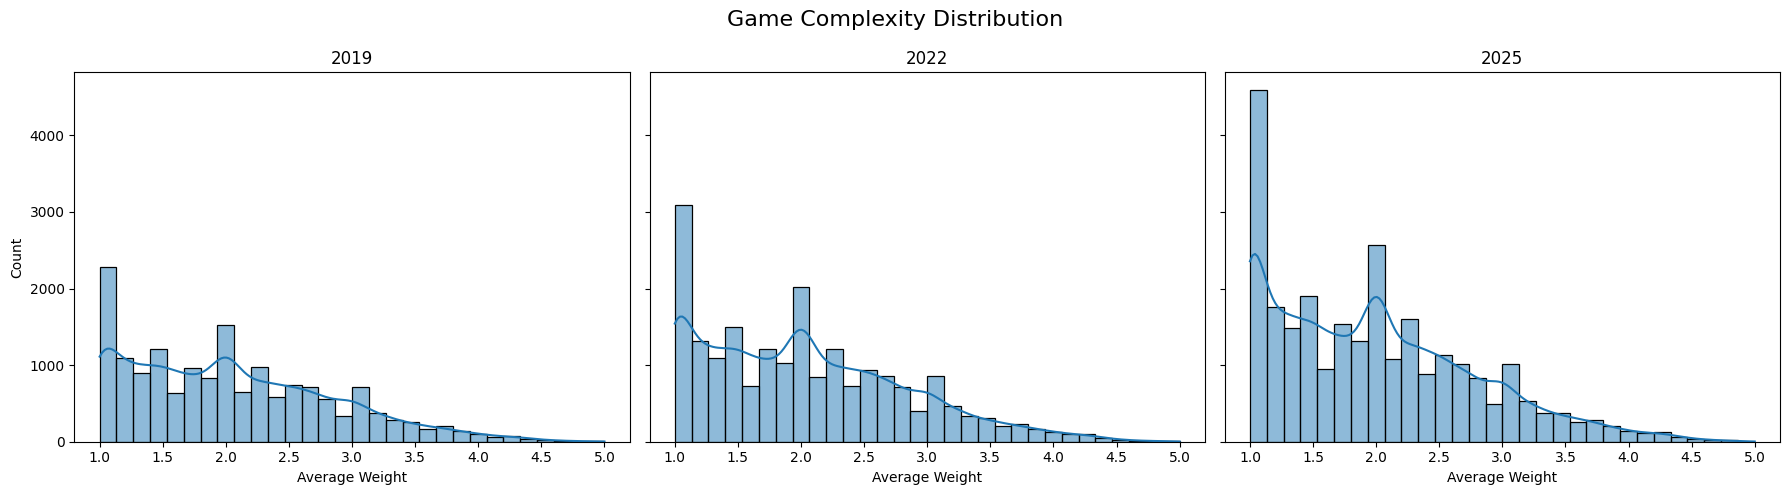

In [59]:
#Game complexity distribution
plot_distribution(snapshots, 'averageweight', 'Game Complexity Distribution', 'Average Weight')

Most of the games (in the 3 years) have an average weight (complexity) between 1 and 2. This is most apparent in the board games scraped in the data from 2025.

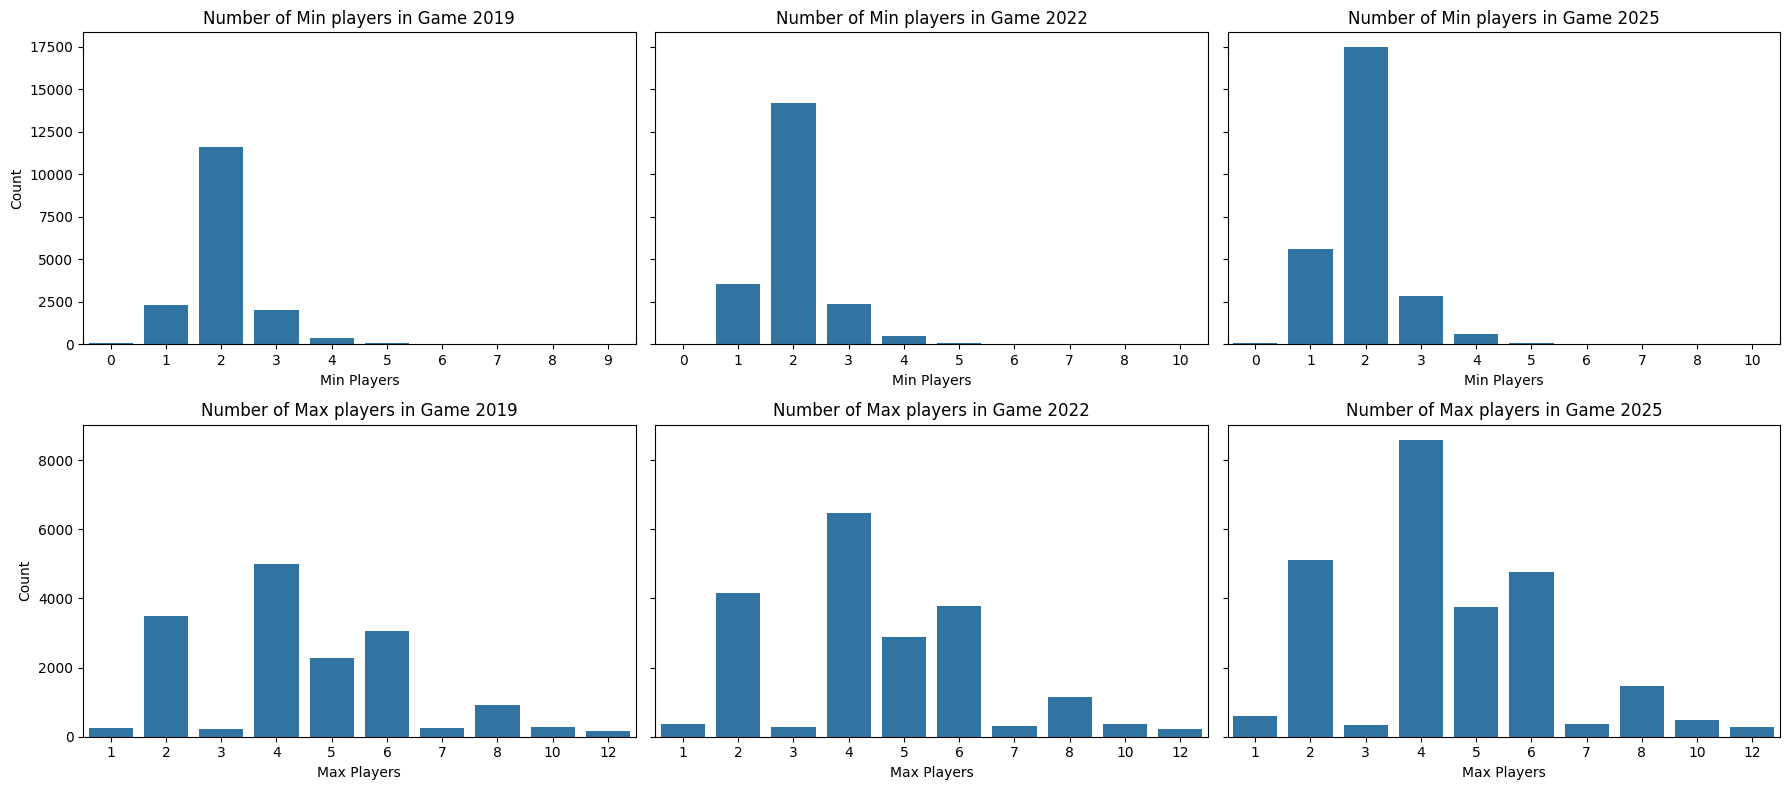

In [60]:
#Min/Max players distribution
fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharey='row')

for i, (label, df) in enumerate(snapshots.items()):
    top_min = df['minplayers'].value_counts().nlargest(10)
    top_max = df['maxplayers'].value_counts().nlargest(10) #Maxplayers can go up to 999 (indicating no max) => on barplot there is a gap. No values from 11 till 999

    sns.barplot(x=top_min.index, y=top_min.values, ax=axs[0, i])
    axs[0, i].set_title(f"Number of Min players in Game {label}")
    axs[0, i].set_xlabel("Min Players")

    sns.barplot(x=top_max.index, y=top_max.values, ax=axs[1, i])
    axs[1, i].set_title(f"Number of Max players in Game {label}")
    axs[1, i].set_xlabel("Max Players")

axs[0, 0].set_ylabel("Count")
axs[1, 0].set_ylabel("Count")

plt.tight_layout()
plt.show()


The board games in the 3 years follow a similar distribution in the minimum and maximum number of players. The majority of the games have a minimum number of 2 players.

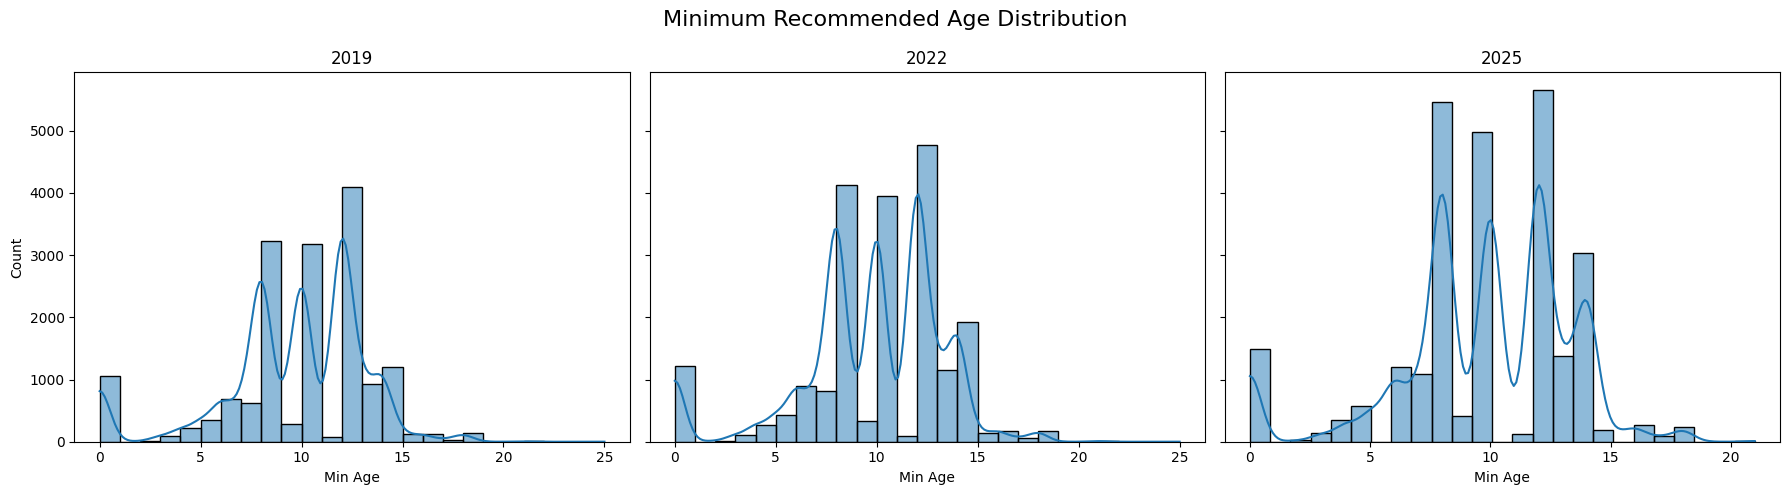

In [61]:
#Minimum age distribution
plot_distribution(snapshots, 'minage', 'Minimum Recommended Age Distribution', 'Min Age', bins=25)

Most of the games have a recommended age of at least 8+ years.

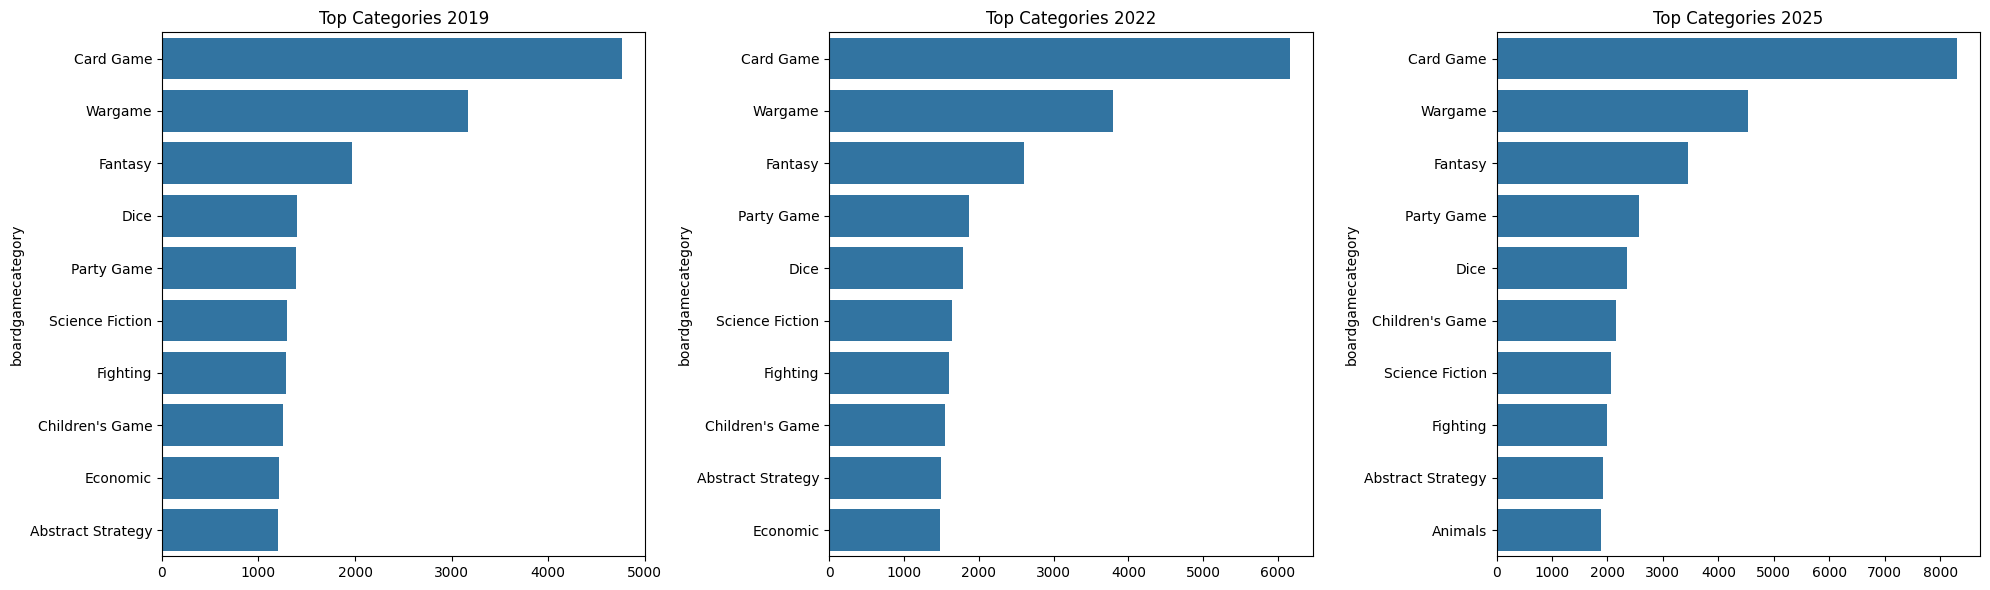

In [62]:
#Top Categories (not mutually excusive - we will need to figure out a way to group similar categories into one for better analysis)
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=False)
for i, (label, df) in enumerate(snapshots.items()):
    exploded = df.explode('boardgamecategory')
    top_cat = exploded['boardgamecategory'].value_counts().head(10)
    sns.barplot(x=top_cat.values, y=top_cat.index, ax=axs[i])
    axs[i].set_title(f"Top Categories {label}")
plt.tight_layout()
plt.show()

We have some changes in the most common catgories between the years. However, this needs further inspection as these categories are not mutually exclusive. We will need to figure out a way to group similar categories into one for better analysis.

After taking a look at the general statistics of the board games' properties in the 3 years seperately, we look at how the general trends evolved over the years.

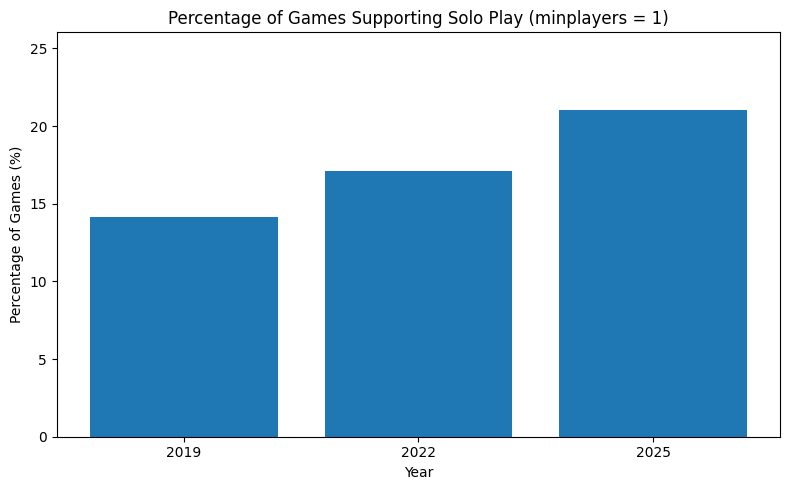

In [63]:
solo_percentage = {
    '2019': (games19['minplayers'] == 1).sum() / len(games19) * 100,
    '2022': (games22['minplayers'] == 1).sum() / len(games22) * 100,
    '2025': (games25['minplayers'] == 1).sum() / len(games25) * 100
}

plt.figure(figsize=(8, 5))
plt.bar(solo_percentage.keys(), solo_percentage.values())
plt.title('Percentage of Games Supporting Solo Play (minplayers = 1)')
plt.ylabel('Percentage of Games (%)')
plt.xlabel('Year')
plt.ylim(0, max(solo_percentage.values()) + 5)
plt.tight_layout()
plt.show()


The figure shows a rise in the percentage of games that support solo play (minimum number of players = 1) over the years. This is important for our analysis of board games across the pandemic. We can explore the percentage differences across the years for the other properties as well.

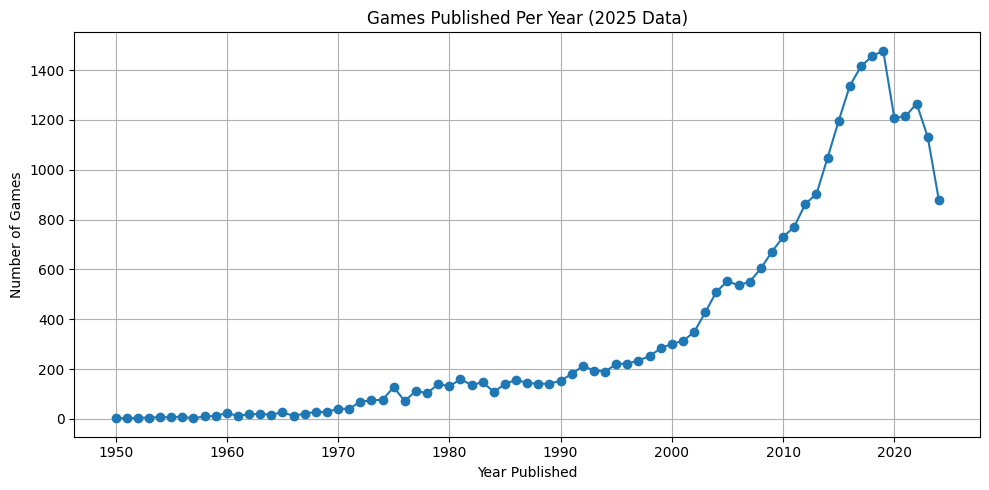

In [64]:
pub_counts_25 = games25['yearpublished'].value_counts().sort_index()
pub_counts_25 = pub_counts_25[pub_counts_25.index >= 1950]
pub_counts_25 = pub_counts_25[pub_counts_25.index <= 2024] #We remove 2025 since it will naturally show a decrease (spans 2 months of 2025 only)

plt.figure(figsize=(10, 5))
plt.plot(pub_counts_25.index, pub_counts_25.values, marker='o')
plt.title("Games Published Per Year (2025 Data)")
plt.xlabel("Year Published")
plt.ylabel("Number of Games")
plt.grid(True)
plt.tight_layout()
plt.show()


The figure shows a decrease in the number of games published between 2019 and 2021, which could offer insight in our analysis of the possible impact of the pandemic.

Next, we perform a country-based analysis.

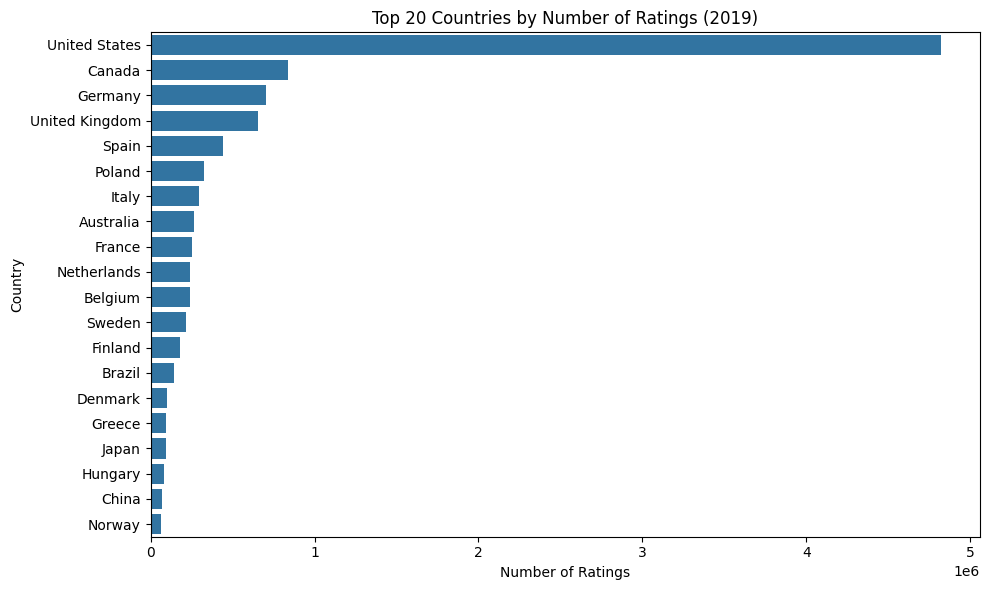

In [65]:
#Countries with most ratings
country_counts = ratings_by_country['country'].value_counts().sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=country_counts.values, y=country_counts.index)
plt.title('Top 20 Countries by Number of Ratings (2019)')
plt.xlabel('Number of Ratings')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

We have the most ratings from users in the United States and Germany.

In [66]:
def top_n_games_by_country(country, n=4):
  country_ratings = ratings_by_country[ratings_by_country['country'] == country]
  avg_ratings = country_ratings.groupby('ID')['rating'].mean().sort_values(ascending=False).head(n)
  avg_ratings = avg_ratings.reset_index()
  avg_ratings['name'] = avg_ratings['ID'].map(games19.name)
  top_game_names = avg_ratings['name'].tolist()
  top_game_names

  print(f"The top {n} games in {country} are:")
  for i in range(len(top_game_names)):
      print(f"{i+1}. {top_game_names[i]}")
  print("\n")

In [67]:
top_n_games_by_country("United States")
top_n_games_by_country("Germany")

The top 4 games in United States are:
1. Bitcoin Hackers
2. DiceWar: Roots of Mali
3. UltraQuest: Gold, Ruhm! und Ehre!
4. Terminator Salvation


The top 4 games in Germany are:
1. War in Europe (second edition)
2. Party Animals
3. GridIron Master
4. 3 Man Chess




Next, we will look at the average complexity of games per country.

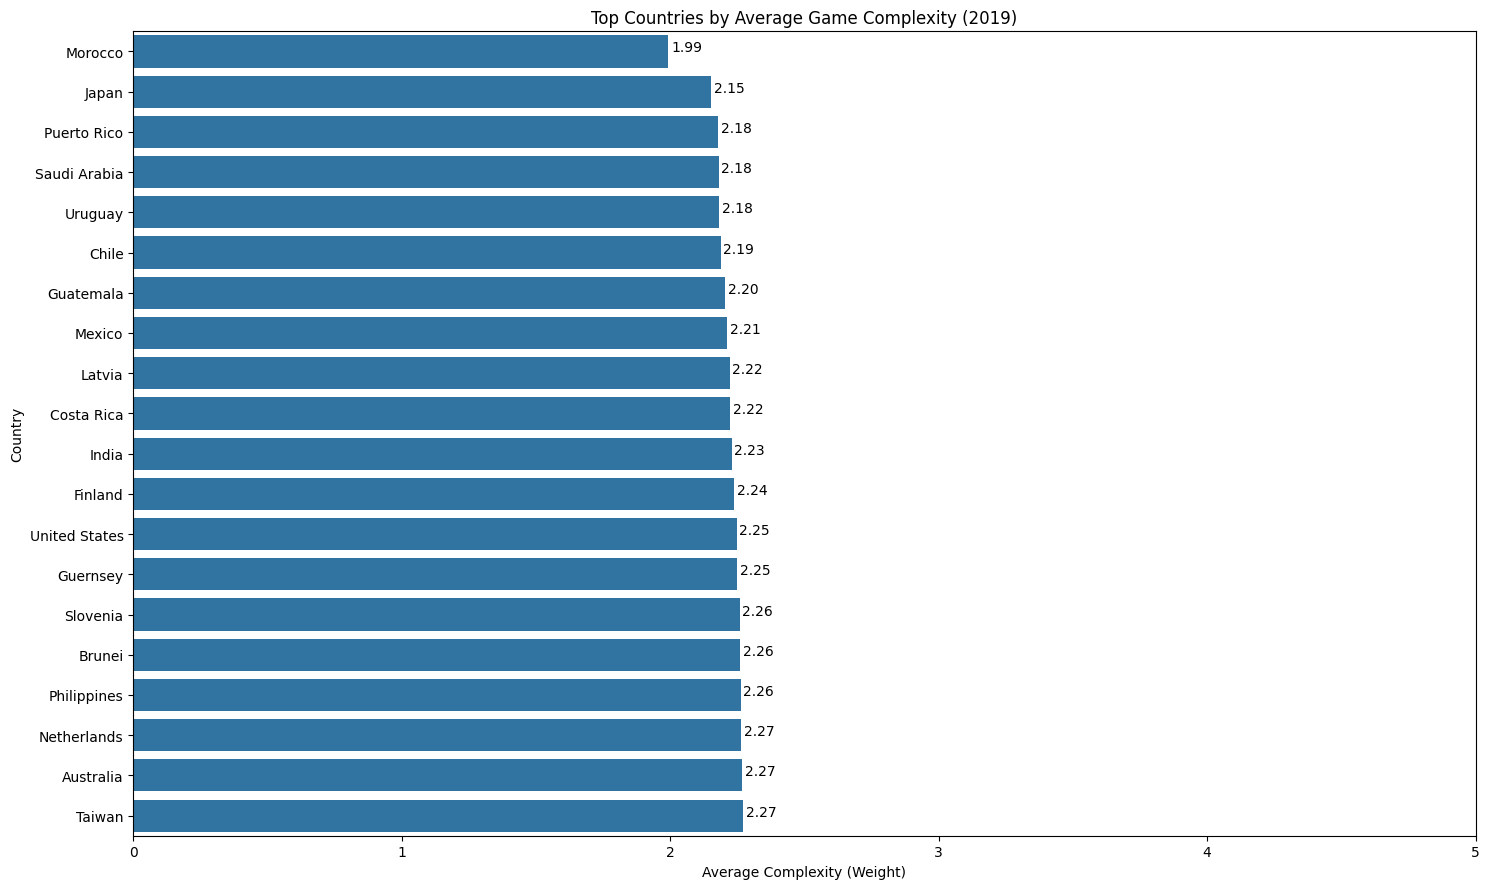

In [68]:
complexity_country = pd.merge(
    ratings_by_country,
    games19[['averageweight']], #only need complexity
    left_on='ID',
    right_index=True,
    how='inner'
)

avg_complexity = (
    complexity_country
    .groupby('country')['averageweight']
    .agg(['mean', 'count'])
    .query('count >= 400')  #filter to countries with 400+ ratings
    .sort_values('mean', ascending=True)
    .head(20)
)

plt.figure(figsize=(15, 9))
ax = sns.barplot(
    x=avg_complexity['mean'],
    y=avg_complexity.index,
)

for i, value in enumerate(avg_complexity['mean']):
    ax.text(value + 0.01, i, f"{value:.2f}")

plt.title("Top Countries by Average Game Complexity (2019)")
plt.xlabel("Average Complexity (Weight)")
plt.ylabel("Country")
plt.xlim(0, 5)
plt.tight_layout()
plt.show()

Some countries such as Morocco have a preference for easier games.

Is there a correlation between the complexity of the game and the Bayes rating?
We will explore that in the last section.

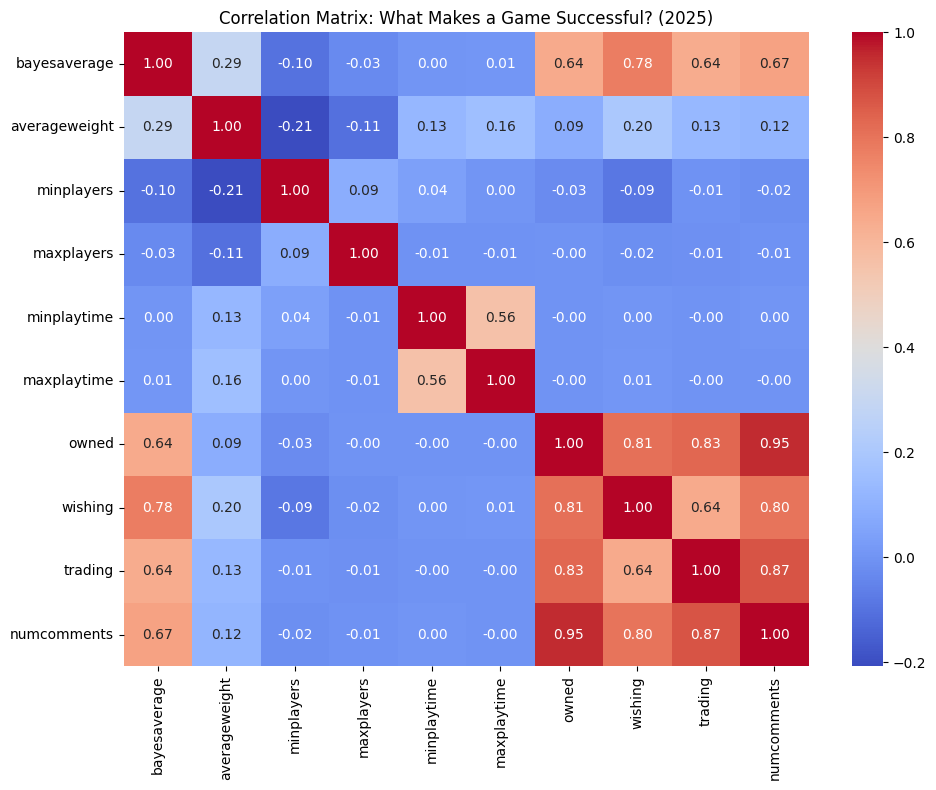

In [69]:
features = [
    'bayesaverage', 'averageweight',
    'minplayers', 'maxplayers',
    'minplaytime', 'maxplaytime',
    'owned', 'wishing', 'trading',
    'numcomments'
]

correlation_df = games25[features]
correlation_matrix = correlation_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix: What Makes a Game Successful? (2025)")
plt.tight_layout()
plt.show()

This figure shows that some parameters, such as 'wishing' and 'numcomments', may be correlated with a higher Bayes average. While these insights may seem intuitive, we can further explore the recipe for success through hypothesis testing.